In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import gc
from google.colab import drive

# --- Configuration ---
FILE_PATH = "/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/gongguan_model_ready_features.parquet.gz"
FORECAST_HORIZON = 6

# --- Mount Drive ---
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

Mounted at /content/drive
✅ Google Drive mounted successfully.


In [ ]:
print("\n--- Loading and preparing data... ---")
data = pd.read_parquet(FILE_PATH)
data['time'] = pd.to_datetime(data['time']) # Ensure time column is datetime
data.sort_values(['sno', 'time'], inplace=True)

# Create 6 target columns, one for each future step
target_cols = []
for i in range(1, FORECAST_HORIZON + 1):
    col_name = f'target_t+{i}'
    data[col_name] = data.groupby('sno')['occupancy_ratio'].shift(-i)
    target_cols.append(col_name)

# Drop rows where any of the new targets are NaN
data.dropna(subset=target_cols, inplace=True)
print("✅ Data loaded and target variables created.")


--- Loading and preparing data... ---
✅ Data loaded and target variables created.


In [ ]:
print("\n--- Creating month-based train, validation, and test splits... ---")

# --- 1. Define Cutoff Dates Based on Fixed Periods ---
start_date = data['time'].min()
TRAINING_CUTOFF_DATE = start_date + pd.DateOffset(months=10)
VALIDATION_CUTOFF_DATE = TRAINING_CUTOFF_DATE + pd.DateOffset(months=2)

print(f"Data starts on: {start_date}")
print(f"\nTraining set ends on:   {TRAINING_CUTOFF_DATE}")
print(f"Validation set ends on: {VALIDATION_CUTOFF_DATE}")

# --- 2. Create the Datasets ---
train_set = data[data['time'] < TRAINING_CUTOFF_DATE]
val_set = data[(data['time'] >= TRAINING_CUTOFF_DATE) & (data['time'] < VALIDATION_CUTOFF_DATE)]
test_set = data[data['time'] >= VALIDATION_CUTOFF_DATE]

# --- 3. Create Feature/Target DataFrames ---
X_train = train_set.drop(columns=target_cols + ['time', 'sno'])
Y_train = train_set[target_cols]
X_val = val_set.drop(columns=target_cols + ['time', 'sno'])
Y_val = val_set[target_cols]
X_test = test_set.drop(columns=target_cols + ['time', 'sno'])
Y_test = test_set[target_cols]

print("\n--- Data Split Summary ---")
print(f"Training set:   From {train_set['time'].min().date()} to {train_set['time'].max().date()} ({len(X_train)} rows)")
print(f"Validation set: From {val_set['time'].min().date()} to {val_set['time'].max().date()} ({len(X_val)} rows)")
print(f"Test set:       From {test_set['time'].min().date()} to {test_set['time'].max().date()} ({len(X_test)} rows)")

# Clean up memory
del data, train_set, val_set, test_set
gc.collect()


--- Creating month-based train, validation, and test splits... ---
Data starts on: 2024-05-04 00:00:00

Training set ends on:   2025-03-04 00:00:00
Validation set ends on: 2025-05-04 00:00:00

--- Data Split Summary ---
Training set:   From 2024-05-04 to 2025-03-03 (4596480 rows)
Validation set: From 2025-03-04 to 2025-05-03 (922320 rows)
Test set:       From 2025-05-04 to 2025-06-22 (755370 rows)


0

In [ ]:
print("\n--- Training 6 separate LightGBM models... ---")
models = {} # Dictionary to store the trained models

for i in range(FORECAST_HORIZON):
    step_name = f't+{i+1}'
    print(f"--- Training model for {step_name} ---")

    y_train_step = Y_train[f'target_{step_name}']
    y_val_step = Y_val[f'target_{step_name}']

    lgbm = lgb.LGBMRegressor(objective='regression_l1', n_estimators=1000, learning_rate=0.05,
                             num_leaves=31, n_jobs=-1, seed=42)

    lgbm.fit(X_train, y_train_step,
             eval_set=[(X_val, y_val_step)],
             eval_metric='l1',
             callbacks=[lgb.early_stopping(100, verbose=False)])

    models[step_name] = lgbm
print("✅ All 6 models have been trained.")


--- Training 6 separate LightGBM models... ---
--- Training model for t+1 ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.305984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2427
[LightGBM] [Info] Number of data points in the train set: 4596480, number of used features: 39
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.263158
--- Training model for t+2 ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.285994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

In [ ]:
print("\n--- Generating predictions on the final test set... ---")
y_pred_test = pd.DataFrame(index=X_test.index)

for step, model in models.items():
    target_col = f"target_{step}"
    y_pred_test[target_col] = model.predict(X_test)
print("✅ Predictions for the test set generated.")


--- Final Detailed Evaluation on the TEST SET ---
Re-linking predictions with station IDs...
✅ Station IDs linked.

Calculating Mean Absolute Error for each station...
✅ Best and worst stations identified.

--- Overall Average Test Set Metrics (All Stations) ---
Overall MAE:  0.0824, RMSE: 0.1537, R²: 0.7410

--- Per-Station Metrics for the 3 BEST Performing Stations ---
  Station 500119057: MAE = 0.0371, RMSE = 0.0945, R² = 0.7948
  Station 500119006: MAE = 0.0379, RMSE = 0.0680, R² = 0.9314
  Station 500106037: MAE = 0.0414, RMSE = 0.0756, R² = 0.9194

--- Per-Station Metrics for the 3 WORST Performing Stations ---
  Station 500101021: MAE = 0.1526, RMSE = 0.2492, R² = 0.4200
  Station 500101014: MAE = 0.1726, RMSE = 0.2531, R² = 0.2788
  Station 500101018: MAE = 0.1970, RMSE = 0.2952, R² = 0.2513

--- Visualizing t+6 Forecasts for BEST Stations ---


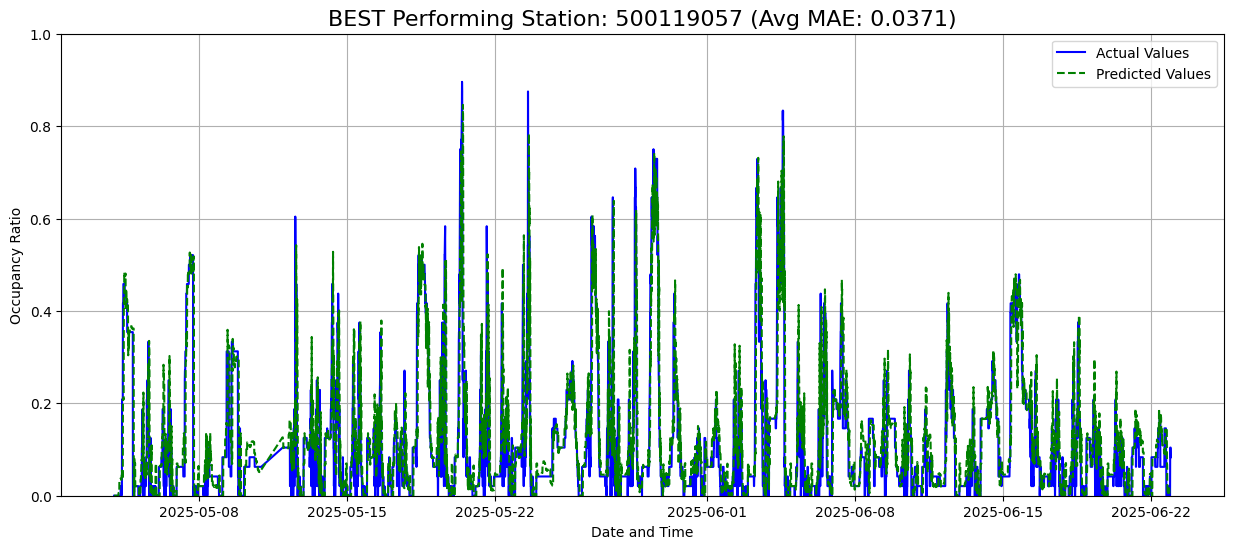

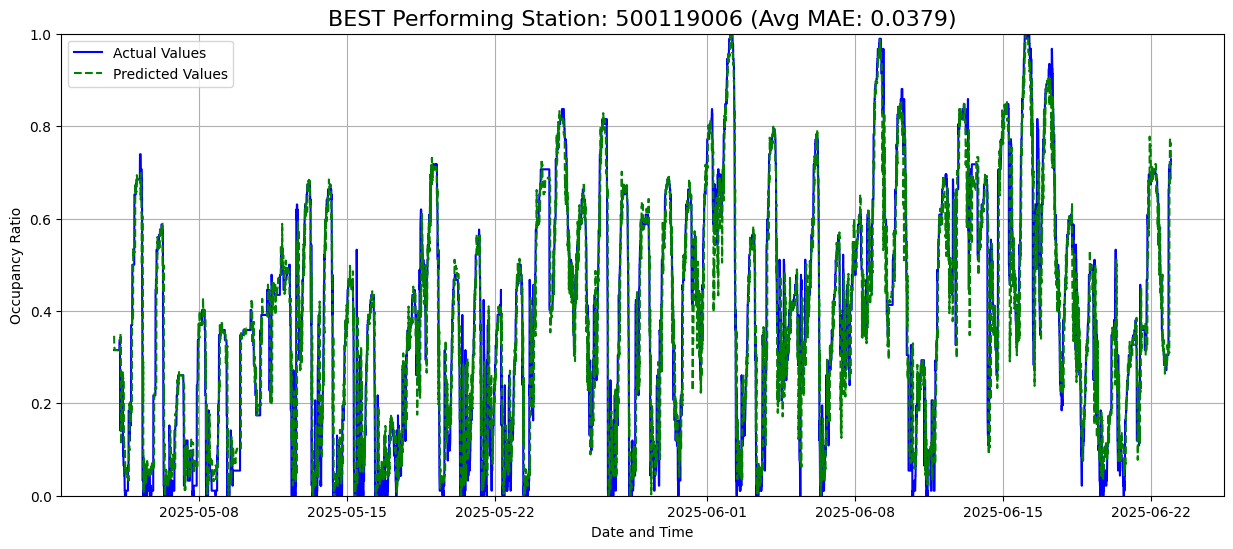

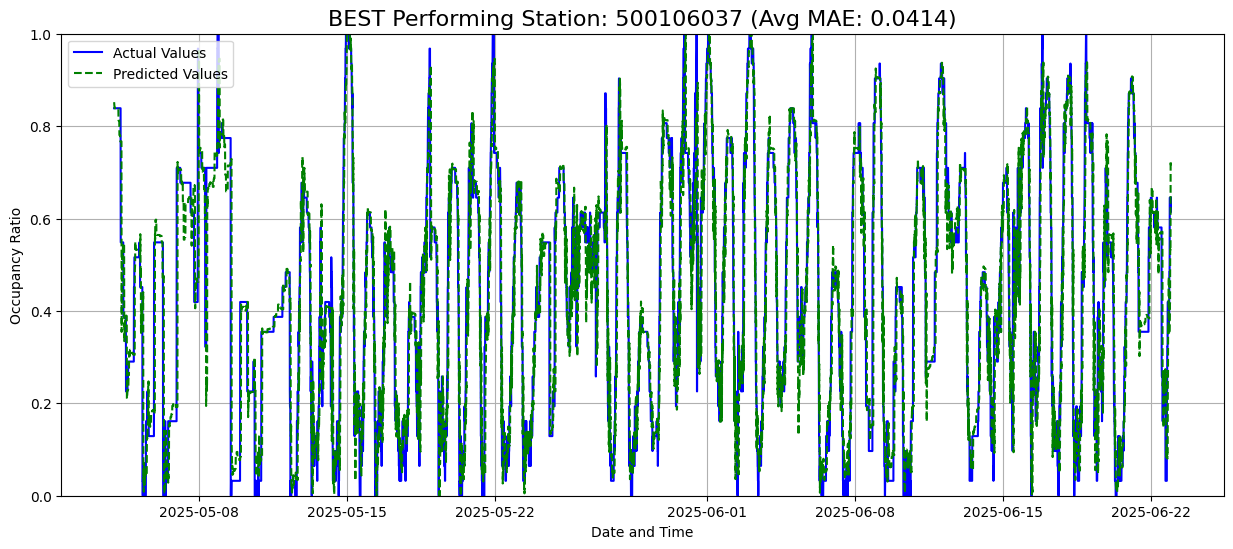


--- Visualizing t+6 Forecasts for WORST Stations ---


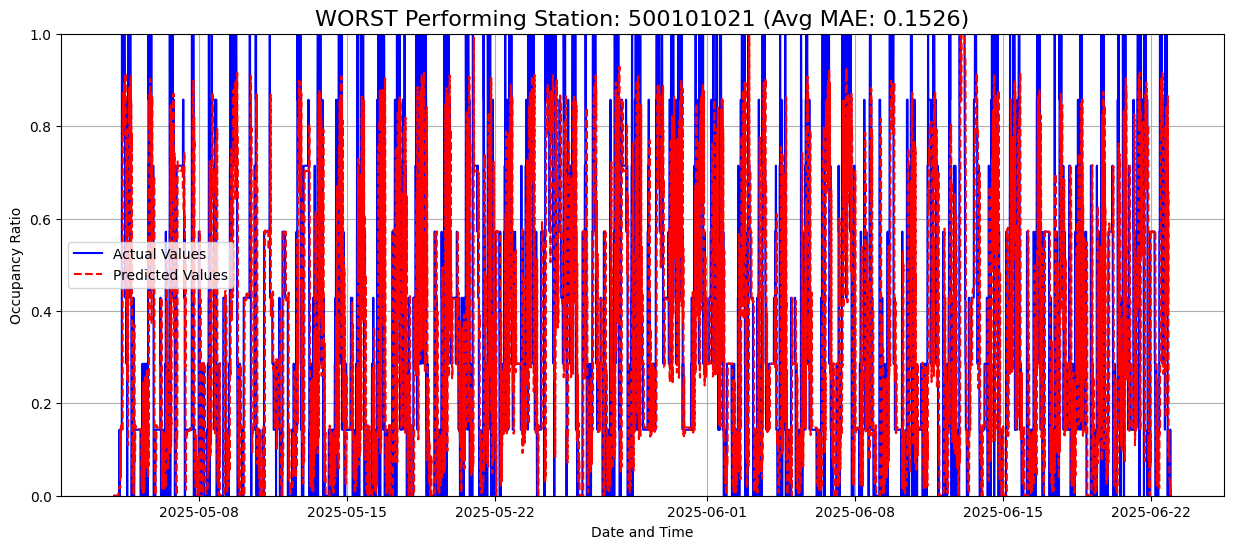

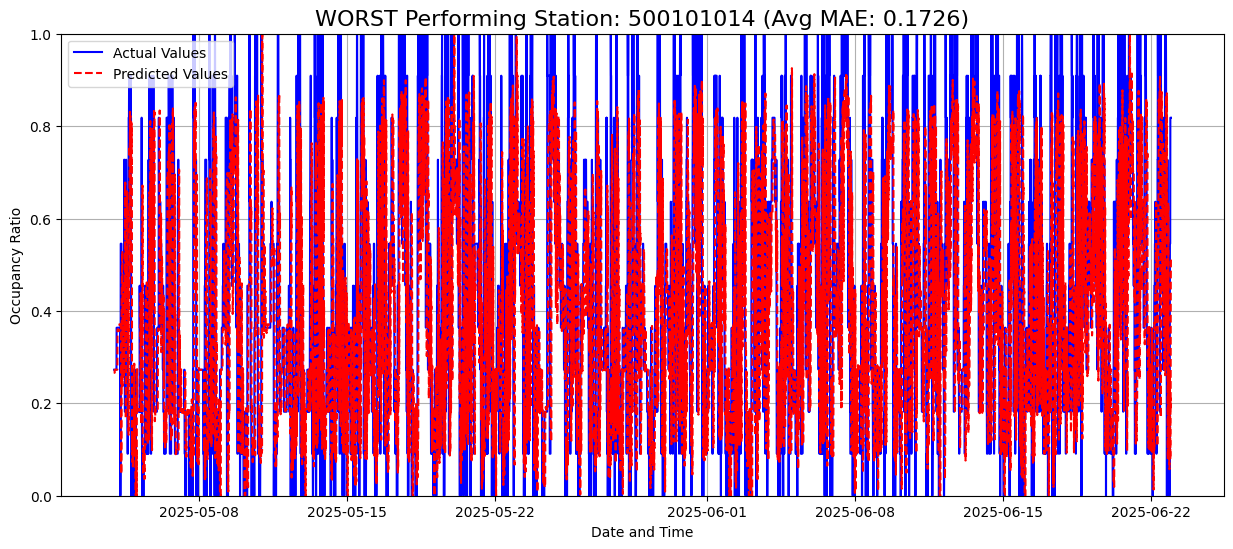

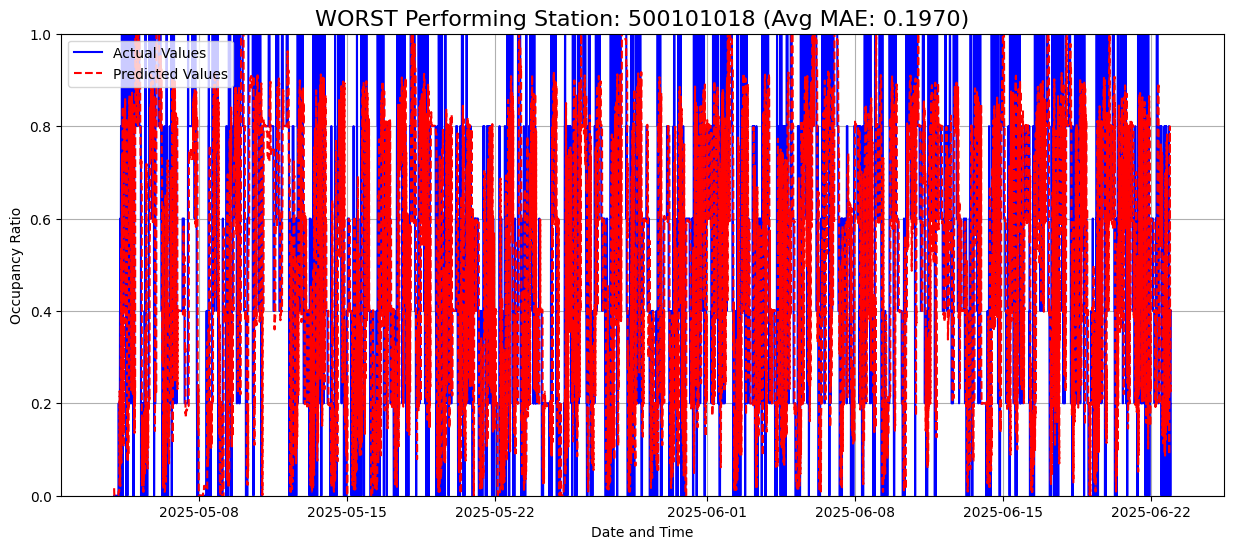


--- Plotting Feature Importance for 1-Hour Ahead Forecast (t+6) ---


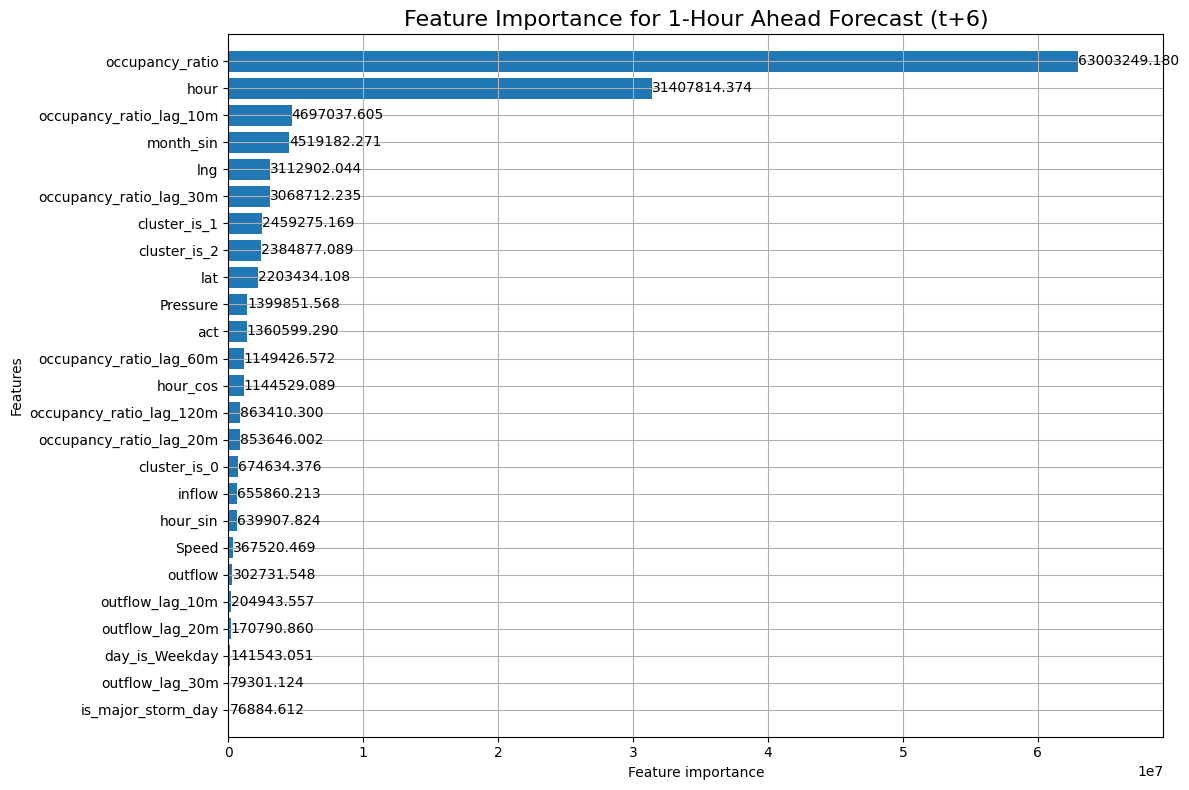

In [ ]:
# ==============================================================================
# Final Cell: Comprehensive Evaluation on the TEST SET with Feature Importance
# ==============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

print("\n--- Final Detailed Evaluation on the TEST SET ---")

# --- 1. Re-link Predictions with Station IDs ---
print("Re-linking predictions with station IDs...")
data_identifiers = pd.read_parquet(FILE_PATH)[['time', 'sno']]
test_identifiers = data_identifiers[data_identifiers['time'] >= VALIDATION_CUTOFF_DATE]
Y_test_with_ids = Y_test.join(test_identifiers)
y_pred_test_with_ids = y_pred_test.join(test_identifiers)
print("✅ Station IDs linked.")

# --- 2. Calculate Per-Station Error and Identify Best/Worst ---
print("\nCalculating Mean Absolute Error for each station...")
station_errors = {}
unique_stations_in_test = Y_test_with_ids['sno'].unique()
for station_id in unique_stations_in_test:
    actuals = Y_test_with_ids[Y_test_with_ids['sno'] == station_id][target_cols]
    preds = y_pred_test_with_ids[y_pred_test_with_ids['sno'] == station_id][target_cols]
    station_errors[station_id] = np.mean(np.abs(actuals.values - preds.values))

errors_df = pd.DataFrame(list(station_errors.items()), columns=['sno', 'mae']).sort_values('mae')
best_stations_ids = errors_df.head(3)['sno'].tolist()
worst_stations_ids = errors_df.tail(3)['sno'].tolist()
print("✅ Best and worst stations identified.")

# --- 3. Helper function to calculate metrics ---
def calculate_subset_metrics(station_ids, y_true_df, y_pred_df):
    y_true_subset = y_true_df[y_true_df['sno'].isin(station_ids)][target_cols]
    y_pred_subset = y_pred_df[y_pred_df['sno'].isin(station_ids)][target_cols]
    mae = mean_absolute_error(y_true_subset, y_pred_subset)
    mse = mean_squared_error(y_true_subset, y_pred_subset)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_subset, y_pred_subset, multioutput='uniform_average')
    return mae, mse, rmse, r2

# --- 4. Calculate and Display All Metrics ---
metrics_overall = calculate_subset_metrics(unique_stations_in_test, Y_test_with_ids, y_pred_test_with_ids)
print("\n--- Overall Average Test Set Metrics (All Stations) ---")
print(f"Overall MAE:  {metrics_overall[0]:.4f}, RMSE: {metrics_overall[2]:.4f}, R²: {metrics_overall[3]:.4f}")

print("\n--- Per-Station Metrics for the 3 BEST Performing Stations ---")
for station_id in best_stations_ids:
    metrics = calculate_subset_metrics([station_id], Y_test_with_ids, y_pred_test_with_ids)
    print(f"  Station {station_id}: MAE = {metrics[0]:.4f}, RMSE = {metrics[2]:.4f}, R² = {metrics[3]:.4f}")

print("\n--- Per-Station Metrics for the 3 WORST Performing Stations ---")
for station_id in worst_stations_ids:
    metrics = calculate_subset_metrics([station_id], Y_test_with_ids, y_pred_test_with_ids)
    print(f"  Station {station_id}: MAE = {metrics[0]:.4f}, RMSE = {metrics[2]:.4f}, R² = {metrics[3]:.4f}")

# --- 5. Plot the Forecasts for Best and Worst Stations ---
horizon_to_plot = 't+6'
target_col_to_plot = f'target_{horizon_to_plot}'

def plot_station_forecast(station_id, performance_type, color):
    actuals = Y_test_with_ids[Y_test_with_ids['sno'] == station_id]
    predictions = y_pred_test_with_ids[y_pred_test_with_ids['sno'] == station_id]
    mae = errors_df[errors_df['sno'] == station_id]['mae'].iloc[0]
    valid_indices = actuals[target_col_to_plot] >= 0
    actuals_filtered = actuals[valid_indices]; predictions_filtered = predictions[valid_indices]

    plt.figure(figsize=(15, 6))
    plt.plot(actuals_filtered['time'], actuals_filtered[target_col_to_plot], label='Actual Values', color='blue')
    plt.plot(predictions_filtered['time'], predictions_filtered[target_col_to_plot], label='Predicted Values', color=color, linestyle='--')
    plt.title(f'{performance_type} Performing Station: {station_id} (Avg MAE: {mae:.4f})', fontsize=16)
    plt.xlabel('Date and Time'); plt.ylabel('Occupancy Ratio'); plt.legend(); plt.grid(True); plt.ylim(0, 1)
    plt.show()

print(f"\n--- Visualizing {horizon_to_plot} Forecasts for BEST Stations ---")
for station_id in best_stations_ids:
    plot_station_forecast(station_id, "BEST", "green")

print(f"\n--- Visualizing {horizon_to_plot} Forecasts for WORST Stations ---")
for station_id in worst_stations_ids:
    plot_station_forecast(station_id, "WORST", "red")


# --- 6. Plot Feature Importance for Furthest Horizon ---
print("\n--- Plotting Feature Importance for 1-Hour Ahead Forecast (t+6) ---")
# Select the model trained for the t+6 horizon
model_to_plot = models['t+6']

fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(model_to_plot, ax=ax, max_num_features=25, importance_type='gain', height=0.8)
plt.title("Feature Importance for 1-Hour Ahead Forecast (t+6)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# Add This Cell at the End of Your LightGBM Notebook
# ==============================================================================
print("\n--- Saving Final Predictions for Comparative Analysis ---")

# Define the directory to save your final results
RESULTS_DIR = "/content/drive/MyDrive/Youbike_Master_Project/final_results/"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Define file paths
actuals_path = os.path.join(RESULTS_DIR, "actuals_test_set.parquet")
lightgbm_preds_path = os.path.join(RESULTS_DIR, "predictions_lightgbm.parquet")

try:
    # --- 1. Save the Actuals (only need to do this once) ---
    # We save Y_test_with_ids because it includes the crucial 'sno' and 'time' columns
    if not os.path.exists(actuals_path):
        Y_test_with_ids.to_parquet(actuals_path)
        print(f"✅ Actuals saved to: {actuals_path}")
    else:
        print("✅ Actuals file already exists.")

    # --- 2. Save the LightGBM Predictions ---
    # We also save y_pred_test_with_ids to keep the 'sno' and 'time' for easy merging
    y_pred_test_with_ids.to_parquet(lightgbm_preds_path)
    print(f"✅ LightGBM predictions saved to: {lightgbm_preds_path}")

except Exception as e:
    print(f"❌ An error occurred while saving the files: {e}")